# Import the necessary libraries

In [1]:
!pip install simplejson
!pip install pyenchant
!apt-get install libenchant-dev


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 4.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 3.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libblkid-dev libenchant1c2a libffi-dev libglib2.0-dev
  libglib2.0-dev-bin libhunspell-1.7-0 libmount-dev libselinux1-dev
  libsepol1-dev libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko libgirepository1.0-dev
  libglib2.0-doc libgdk-pixbuf2.0-bin | libgdk-pixbuf2.0-dev libxml2-utils
The following NEW 

In [2]:
# Import the necessary libraries
import re
import gzip
import nltk
import shutil
import string
import joblib  
import enchant
import simplejson
import numpy as np
import pandas as pd
import pickle as pkl
import urllib.request
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats import randint, uniform
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Train Data

In [4]:
# Set the URL of the file to download
url = "http://snap.stanford.edu/data/amazon/Electronics.txt.gz"

# Set the local file path to save the downloaded file
local_file_path = "/content/Electronics.txt.gz"

# Download the file from the URL and save it to the local file path
with urllib.request.urlopen(url) as response, open(local_file_path, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)


In [5]:
with gzip.open('/content/Electronics.txt.gz', 'rt') as file:
    lines = file.readlines()

In [6]:
lines

['product/productId: B0000630MQ\n',
 'product/title: Kodak Max K2000 Battery Charger with 4 NiMH AA Batteries\n',
 'product/price: unknown\n',
 'review/userId: A2F6FARSB1VL6Q\n',
 'review/profileName: "frumpy16"\n',
 'review/helpfulness: 2/2\n',
 'review/score: 5.0\n',
 'review/time: 1072915200\n',
 'review/summary: Great charger\n',
 'review/text: I recently bought this charger kit from Amazon and I am quite happy with my purchase. The folding plug is nice for storage. The included 1850 mAh batteries last for a long time in my Nikon Coolpix 2100. One of the best features of the charger is that each battery is charged separately (as opposed to in pairs) so that each battery gets just the right amount of charge. The short 3 hour charge time is great as well. The batteries do not get overly warm while charging either.Overall, this is a good charger for a good price. If you have a high drain device, the Kodak K2000 should keep you playing for a long time.\n',
 '\n',
 'product/productId: B

In [7]:
data = [{}]
for line in lines:
    if line.startswith('product/') or line.startswith('review/'):
        key, value = line.strip().split(':', 1)  # split on the first colon only
        data[-1][key] = value.strip()
    else:
        data.append({})

In [8]:
df = pd.DataFrame(data)

# Gathering Test Data

In [9]:
Creative_products = df[df["product/title"].str.startswith("Creative", na=False)]


Data Selection of CREATIVE BRAND

In [10]:

filtered_df = Creative_products.copy()
# re-index the filtered DataFrame and drop the old index
df=  filtered_df.reset_index(drop=True)


In [11]:
# drop rows with null values
df = df.dropna()
df.isnull().sum()

product/productId     0
product/title         0
product/price         0
review/userId         0
review/profileName    0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64

In [12]:
# Review=sampled_df.copy()
Review=df.copy()

In [13]:
# remove the specified columns
columns_to_remove = ['product/productId', 'product/title', 'product/price', 'review/userId',
                     'review/profileName', 'review/helpfulness', 'review/time', 'review/summary']
Review = Review.drop(columns=columns_to_remove)

In [14]:

Review['User_label'] = Review['review/score'].replace({'5.0': 5, '4.0': 4, '3.0': 3, '2.0': 2, '1.0': 1})

In [15]:
df=Review.copy()

In [16]:
# rename the review/score and review/text columns
df = df.rename(columns={'review/score': 'User_Rating', 'review/text': 'Review'})

###    VADER (Valence Aware Dictionary and sEntiment Reasoner)  Score Calculation


In [17]:
# Import SentimentIntensityAnalyzer and create an sid object
sid = SentimentIntensityAnalyzer()

In [18]:
df['Vader_Scores'] = df['Review'].apply(lambda review: sid.polarity_scores(review))
df['Vader_Compound']  = df['Vader_Scores'].apply(lambda score_dict: score_dict['compound'])


# Labelling Data considering  Class 0 as "Negative", Class 1 as "Neutral" and Class 2 as "Positive".

In [19]:

def Vader_sentiment_label(vader_score):
    if vader_score < 0:
        return 0       # Negative
    elif vader_score < 0.25:
        return 1      # Neutral
    else:
        return 2     # Positive

In [20]:

def User_Sentiment_Label_1(score):   # Based on customer Label
    if score < 2.5:  
        return 0     # 1 and 2 star >  class 0 Negative
    elif score < 4.5: 
        return 1     # 3 and 4 star >  class 1 Neutral
    else:              
        return 2    # 5 star >  class 2 Positive

In [21]:

def User_Sentiment_Label_2(score):   # Based on customer Label
    if score < 2.5:  
        return 0     # 1 and 2 star > class 0 Negative
    elif score < 3.5: 
        return 1    # 3  star >  class 1  Neutral
    else:              
        return 2      #  4 & 5 star >  class 2 Positive

In [22]:
df['Vader_sentiment_label'] = df['Vader_Compound'].apply(Vader_sentiment_label)
# df['Vader_Mlabel'] = df['Vader_Compound'].apply(assign_category_Machine)
df['User_Sentiment_Label_1'] = df['User_label'].apply(User_Sentiment_Label_1)
df['User_Sentiment_Label_2'] = df['User_label'].apply(User_Sentiment_Label_2)

In [23]:
# remove the specified columns
columns_to_remove = ['Vader_Compound','User_Rating', 'Vader_Scores' ]   
df = df.drop(columns=columns_to_remove)
df

Review  User_label  \
0      I just received the Rhomba 128M MP3 player and...           4   
1      Being new to MP3s I really had no idea what to...           4   
2      I ordered this great little player as a birthd...           4   
3      My daughter received this item as a Christmas ...           1   
4      Okay. Here is a write up, that I did, on the c...           5   
...                                                  ...         ...   
15884  I liked the looks and colors for the Creative ...           3   
15885  For years as an audiophile, i've been blowing ...           5   
15886  I've owned Ipods and several other mp3 players...           3   
15887  We got one of these recently and have been usi...           4   
15888  Well, I wish it was as reliable as my old, bri...           3   

       Vader_sentiment_label  User_Sentiment_Label_1  User_Sentiment_Label_2  
0                          2                       1                       2  
1                          2                       1                       2  
2                          2                       1                       2  
3                          2                       0                       0  
4                          2                       2                       2  
...                      ...                     ...                     ...  
15884                      2                       1                       1  
15885                      2                       2                       2  
15886                      2                       1                       1  
15887                      2                       1                       2  
15888                      2                       1                       1  

[15889 rows x 5 columns]

In [24]:
# Define a function to preprocess the text data
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))   
    # Tokenize the text
    tokens = word_tokenize(text)  
    # Remove stopwords
    stopwords_list = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwords_list]  
    # Check for misspelled words
    # english_dict = enchant.Dict("en_US")
    # tokens = [token for token in tokens if english_dict.check(token)]
    #Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  
    # Join the tokens back into text
    text = ' '.join(tokens)  
    return text

In [25]:
# Apply the preprocess function to the text data
df['Review'] = df['Review'].apply(preprocess)


# Split Test Train Data

In [26]:
# Split the data into training and testing sets with stratification
train_data, test_data = train_test_split(df, test_size=0.15, random_state= 17  )   

In [27]:
# X_train =  train_data['Review']
# y_train = train_data['User_Sentiment_Label_2']  
X_test = test_data['Review']
y_test = test_data['User_Sentiment_Label_2']   

# Openning Saved Model  

In [28]:
# Load the best model
best_model = joblib.load('best_model.pkl')

In [29]:
# Test the best model on the test dataset
from sklearn.metrics import accuracy_score
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy score: {test_accuracy:.3f}")

Test accuracy score: 0.812


In [30]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_mat)


Confusion Matrix:
[[ 377    5  152]
 [  52    6  162]
 [  72    4 1554]]


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print precision, recall, and F1-score
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.774
Recall: 0.812
F1-score: 0.775


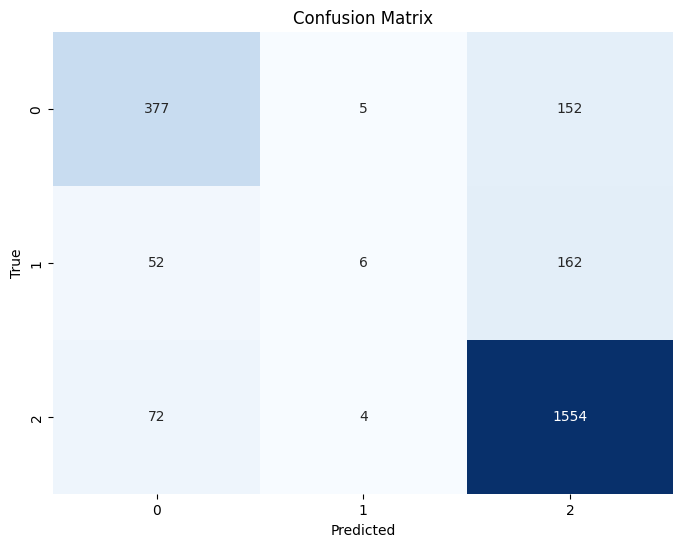

In [32]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the predicted labels in y_pred and true labels in y_test

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [33]:
best_model

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=777)),
                ('classifier',
                 LogisticRegression(C=1.321941148466029, multi_class='ovr',
                                    solver='newton-cg'))])

# Creation of Experimental Data and bringing Outcome

# Experimental Data 1 (only for any text input) **

In [34]:
test_file = "I'm super pleased with this keyboard -- it works as described. The mouse only connects to two devices, unlike the keyboard, which connects to three. This does not impact me whatsoever."

In [35]:
test_df = pd.DataFrame({"index": [0], "text": [test_file]})
test_df["text"] = test_df["text"].apply(preprocess)
x_trial = test_df["text"]
predictions = best_model.predict(x_trial)
# Make predictions on the transformed test data using the saved model
predictions 

array([2])

In [36]:
sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
predicted_sentiment = sentiment_map[predictions[0]]
print("The predicted Review Sentiment is:", predicted_sentiment)

The predicted Review Sentiment is: Positive


## Data Preparation for Experimental Data 

In [37]:
data1 = [{}]
for line in lines:
    if line.startswith('product/') or line.startswith('review/'):
        key, value = line.strip().split(':', 1)  # split on the first colon only
        data1[-1][key] = value.strip()
    else:
        data1.append({})

In [38]:
df1 = pd.DataFrame(data1)

In [39]:
df1

product/productId                                      product/title  \
0              B0000630MQ  Kodak Max K2000 Battery Charger with 4 NiMH AA...   
1              B0000630MQ  Kodak Max K2000 Battery Charger with 4 NiMH AA...   
2              B0000630MQ  Kodak Max K2000 Battery Charger with 4 NiMH AA...   
3              B0000630MQ  Kodak Max K2000 Battery Charger with 4 NiMH AA...   
4              B0000630MQ  Kodak Max K2000 Battery Charger with 4 NiMH AA...   
...                   ...                                                ...   
1241774        B000051JUL                          3Com Audrey Web Appliance   
1241775        B000051JUL                          3Com Audrey Web Appliance   
1241776        B000063W56  Sony ACCCSP Starter Kit for DSCP3 & DSCP5 Digi...   
1241777        B000063W56  Sony ACCCSP Starter Kit for DSCP3 & DSCP5 Digi...   
1241778               NaN                                                NaN   

        product/price   review/userId review/profileName review/helpfulness  \
0             unknown  A2F6FARSB1VL6Q         "frumpy16"                2/2   
1             unknown         unknown            unknown                2/2   
2             unknown  A3P56Q3XEGTBNY      Yisheng Zhang                1/1   
3             unknown         unknown            unknown                3/4   
4             unknown   AZIM9ZTGB8Q12           G. Evans                0/0   
...               ...             ...                ...                ...   
1241774       unknown         unknown            unknown                4/5   
1241775       unknown   AZ2VE6AZ4EW8Q            JMO9876                1/1   
1241776         99.20   AA2CXRGE0GN1S          Y. Hu "Y"                1/1   
1241777         99.20  A3LIWM4DA1TOOP         Y Al-Saleh                1/3   
1241778           NaN             NaN                NaN                NaN   

        review/score review/time                             review/summary  \
0                5.0  1072915200                              Great charger   
1                5.0  1058745600             Super product! I'm very happy.   
2                2.0  1127088000         Problem with charging smaller AAAs   
3                5.0  1068768000               CHECK OUT THE K6000 CHARGER!   
4                5.0  1274313600  Finally a Great recharger with batteries!   
...              ...         ...                                        ...   
1241774          1.0  1010966400    This item was discontinued in May 2001.   
1241775          1.0   985651200                          NOT user friendly   
1241776          5.0  1024963200      Case, Battery and 32 Meg Memory Stick   
1241777          5.0  1023235200                       Sony DSC Starter kit   
1241778          NaN         NaN                                        NaN   

                                               review/text  
0        I recently bought this charger kit from Amazon...  
1        The batteries are excellent (1850's), and the ...  
2        I have had the charger for more than two years...  
3        Greetings. Kodak also has a K6000 charger whic...  
4        I have used and recharged my batteries nearly ...  
...                                                    ...  
1241774  This is not a good buy! Here is a clip from th...  
1241775  We bought this for our Mom with high expectaio...  
1241776  I bought this item because I thought there was...  
1241777  This is a great kit , has all the essentials a...  
1241778                                                NaN  

[1241779 rows x 10 columns]

In [40]:
logitech_products = df1[df1["product/title"].str.startswith("Logitech", na=False)]
logitech_products.isnull().sum()

product/productId     0
product/title         0
product/price         0
review/userId         0
review/profileName    0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64

In [41]:
value_counts = logitech_products["product/title"].value_counts()
#print(value_counts)
value_counts.head(10)

Logitech Harmony 880 Advanced Universal Remote Control                                                        1973
Logitech Pro 9000 PC Internet Camera Webcam with 8.0-Megapixel Video Resolution and Carl Zeiss Lens Optics    1765
Logitech Z-2300 THX-Certified 2.1 Speaker System with Subwoofer                                               1382
Logitech Trackman Wheel Optical (Silver)                                                                       828
Logitech Z-5500 THX-Certified 5.1 Digital Surround Sound Speaker System                                        769
Logitech Harmony 550 Universal Remote Control                                                                  741
Logitech MX Revolution Cordless Laser Mouse (Black)                                                            672
Logitech USB Desktop Microphone (Black/Silver)                                                                 672
Logitech X-140 2.0 Speakers                                                     

In [42]:
# Logitech Harmony 550 Universal Remote Control    # Test 2
# Logitech MX Revolution Cordless Laser Mouse (Black)  # Test 3
# Logitech USB Desktop Microphone (Black/Silver)  # Test 4
# Logitech X-140 2.0 Speakers   # Test 5

# Experimental Data 2 ( for specific Data Frame or CSV)
# Logitech Harmony 550 Universal Remote Control  (With Image Button)

In [43]:
 logitech_Universal_Remote = logitech_products[logitech_products["product/title"].str.startswith("Logitech Harmony 550 Universal Remote Control", na=False)]
 logitech_Universal_Remote = logitech_Universal_Remote.reset_index(drop=True)


In [44]:
logitech_Universal_Remote.head(2)

product/productId                                  product/title  \
0        B000EUGX70  Logitech Harmony 550 Universal Remote Control   
1        B000EUGX70  Logitech Harmony 550 Universal Remote Control   

  product/price   review/userId             review/profileName  \
0       unknown  A2UUEGDBLT7SS8                        C. Less   
1       unknown  A1IMNJPF73W9MH  D. Zartman "Average Consumer"   

  review/helpfulness review/score review/time  \
0                0/0          5.0  1219017600   
1                0/0          5.0  1218931200   

                            review/summary  \
0                         Simply Brilliant   
1  Great remote and GREAT Customer Service   

                                         review/text  
0  I have both this and the 880 and they are awes...  
1  Bought this remote about a year ago from one o...

In [45]:
# remove the specified columns
columns_to_remove = ['product/productId', 'product/title', 'product/price', 'review/userId',
                     'review/profileName', 'review/helpfulness','review/score', 'review/time', 'review/summary']
logitech_Universal_Remote = logitech_Universal_Remote.drop(columns=columns_to_remove)


In [46]:
logitech_Universal_Remote.isnull().sum()

review/text    0
dtype: int64

In [47]:
# logitech_Universal_Remote

In [48]:
logitech_Universal_Remote.to_csv('logitech_Universal_Remote.csv', index=False)


In [49]:
# # Read CSV file into a pandas dataframe
# df111 = pd.read_csv('logitech_Universal_Remote.csv')

In [50]:
x_trial2 = logitech_Universal_Remote["review/text"]
 
predictions = best_model.predict(x_trial2)  
# Make predictions on the transformed test data using the saved model
predictions 
 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [51]:
len(predictions)

741

In [52]:
unique_vals2, val_counts2 = np.unique(predictions, return_counts=True)

In [53]:
unique_vals2 


array([0, 1, 2])

In [54]:
val_counts2

array([ 59,   2, 680])

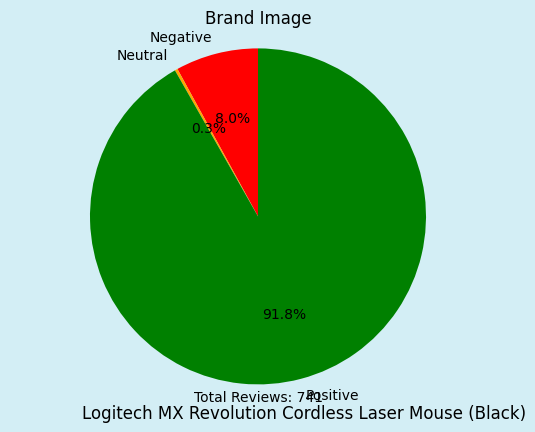

In [55]:
 
import matplotlib.pyplot as plt

labels = ['Negative', 'Neutral', 'Positive']
sizes = val_counts2 / np.sum(val_counts2)
colors = ['red', 'orange', 'green']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.title('Brand Image')
plt.text(-1.05, -1.2, 'Logitech MX Revolution Cordless Laser Mouse (Black)', fontsize=12)
ax1.text(0, -1.1, f'Total Reviews: {np.sum(val_counts2)}', ha='center')
fig1.set_facecolor('#d3eef5')  # set light blue background
plt.show()


# Experimental Data 3 (Data Frame or CSV)
# Logitech MX Revolution Cordless Laser Mouse (Black)  (With Image Button)

In [56]:
 logitech_Laser_Mouse = logitech_products[logitech_products["product/title"].str.startswith("Logitech MX Revolution Cordless Laser Mouse (Black)", na=False)]
 logitech_Laser_Mouse = logitech_Laser_Mouse.reset_index(drop=True)

In [57]:
 
# remove the specified columns
columns_to_remove = ['product/productId', 'product/title', 'product/price', 'review/userId',
                     'review/profileName', 'review/helpfulness','review/score', 'review/time', 'review/summary']
logitech_Laser_Mouse = logitech_Laser_Mouse.drop(columns=columns_to_remove)
x_trial3 = logitech_Laser_Mouse["review/text"]
 
predictions3 = best_model.predict(x_trial3) #.reshape(1, -1))
# Make predictions on the transformed test data using the saved model
predictions3 

array([2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2,

In [58]:
logitech_Laser_Mouse.to_csv('logitech_Laser_Mouse.csv', index=False)

In [59]:
unique_vals3, val_counts3 = np.unique(predictions3, return_counts=True)

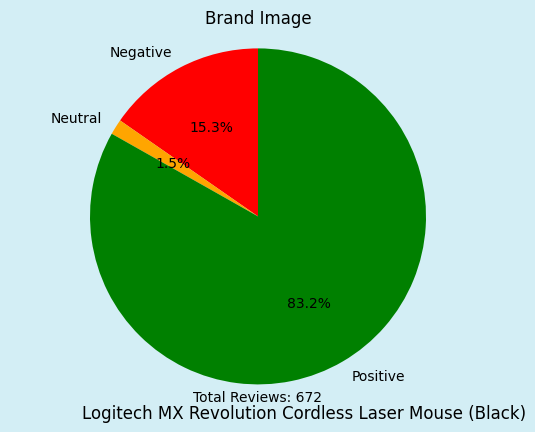

In [60]:
unique_vals3, val_counts3 = np.unique(predictions3, return_counts=True)
import matplotlib.pyplot as plt

labels = ['Negative', 'Neutral', 'Positive']
sizes = val_counts3 / np.sum(val_counts3)
colors = ['red', 'orange', 'green']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.title('Brand Image')
plt.text(-1.05, -1.2, 'Logitech MX Revolution Cordless Laser Mouse (Black)', fontsize=12)
ax1.text(0, -1.1, f'Total Reviews: {np.sum(val_counts3)}', ha='center')
fig1.set_facecolor('#d3eef5')  # set light blue background
plt.show()


# Experimental Data 4 (Data Frame or CSV)
# Logitech USB Desktop Microphone (Black/Silver)  (With Image Button)

In [61]:
logitech_Desktop_Microphone = logitech_products[logitech_products["product/title"].str.startswith("Logitech USB Desktop Microphone (Black/Silver)", na=False)]
logitech_Desktop_Microphone = logitech_Desktop_Microphone.reset_index(drop=True)

In [62]:
# remove the specified columns
columns_to_remove = ['product/productId', 'product/title', 'product/price', 'review/userId',
                     'review/profileName', 'review/helpfulness','review/score', 'review/time', 'review/summary']
logitech_Desktop_Microphone = logitech_Desktop_Microphone.drop(columns=columns_to_remove)
x_trial4 = logitech_Desktop_Microphone["review/text"]
 
predictions4 = best_model.predict(x_trial4)  
# Make predictions on the transformed test data using the saved model
predictions4

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0,
       2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0,

In [63]:
logitech_Desktop_Microphone.to_csv('logitech_Desktop_Microphone.csv', index=False)

In [64]:
unique_vals4, val_counts4 = np.unique(predictions4, return_counts=True)

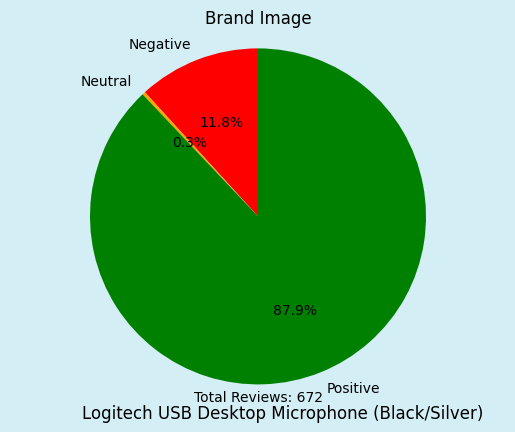

In [65]:
import matplotlib.pyplot as plt

labels = ['Negative', 'Neutral', 'Positive']
sizes = val_counts4 / np.sum(val_counts3)
colors = ['red', 'orange', 'green']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.title('Brand Image')
plt.text(-1.05, -1.2, 'Logitech USB Desktop Microphone (Black/Silver)', fontsize=12)
ax1.text(0, -1.1, f'Total Reviews: {np.sum(val_counts3)}', ha='center')
fig1.set_facecolor('#d3eef5')  # set light blue background
plt.show()

....................................................................

# Experimental Data 5 (Data Frame or CSV)

#Logitech X-140 2.0 Speakers   (With Image Button)

In [ ]:
logitech_Logitech_Speakers  = logitech_products[logitech_products["product/title"].str.startswith("Logitech X-140 2.0 Speakers ", na=False)]
logitech_Logitech_Speakers = logitech_Logitech_Speakers.reset_index(drop=True)
 # remove the specified columns
columns_to_remove = ['product/productId', 'product/title', 'product/price', 'review/userId',
                     'review/profileName', 'review/helpfulness','review/score', 'review/time', 'review/summary']
logitech_Logitech_Speakers = logitech_Logitech_Speakers.drop(columns=columns_to_remove)

x_trial5 = logitech_Universal_Remote["review/text"]
 
predictions5 = best_model.predict(x_trial5) #.reshape(1, -1))
# Make predictions on the transformed test data using the saved model

unique_vals5, val_counts5 = np.unique(predictions5, return_counts=True)

In [ ]:
logitech_Logitech_Speakers.to_csv('logitech_Logitech_Speakers.csv', index=False)

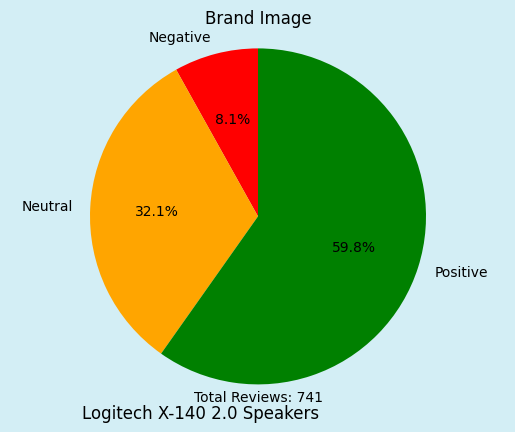

In [ ]:
import matplotlib.pyplot as plt

labels = ['Negative', 'Neutral', 'Positive']
sizes = val_counts5 / np.sum(val_counts3)
colors = ['red', 'orange', 'green']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.title('Brand Image')
plt.text(-1.05, -1.2, 'Logitech X-140 2.0 Speakers ', fontsize=12)
ax1.text(0, -1.1, f'Total Reviews: {np.sum(val_counts5)}', ha='center')
fig1.set_facecolor('#d3eef5')  # set light blue background
plt.show()

...................................THE END.....................................